In [1]:
#esse notebook contém os scripts para criar novos datasets;
import pandas as pd
import numpy as np
import time
import datetime
import re

years = [2015, 2016, 2017]
datapath = '../data/bicicletar/clean_data_'
files = [pd.read_pickle('%s%d.pkl' % (datapath,year)) for year in years]
# file2015 = 
# file2016 = pd.read_pickle(datapath+'2016.pkl')
# file2017 = pd.read_pickle(datapath+'2017.pkl')
all_data = pd.concat(files,ignore_index=True)

/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [17]:
#cria dataset com o número de viagens (de cada categoria) por ano (2014,2015,2016,2017)

def num_of_rides_per_year():
    date15 = datetime.datetime(2015, 1, 1)
    data2014 = all_data[all_data['datetime_retirada'] < date15]

    date16 = datetime.datetime(2016, 1, 1)
    data2015 = all_data[(date15 <= all_data['datetime_retirada']) & (all_data['datetime_retirada'] < date16)]

    date17 = datetime.datetime(2017, 1, 1)
    data2016 = all_data[(date16 <= all_data['datetime_retirada']) & (all_data['datetime_retirada'] < date17)]
    data2017 = all_data[date17 <= all_data['datetime_retirada']]

    data2014.shape[0],data2015.shape[0],data2016.shape[0],data2017.shape[0]

    #dataset = pd.DataFrame(columns=['bicicletar','minibicicletar','tecnica','menos_4_min','mais_um_dia','minibicicletar_bug'])
    dataset = []
    for data in[data2014,data2015,data2016,data2017]:
        dataset.append(data['tipo_viagem'].value_counts().to_dict())
    
    dataset = pd.DataFrame(dataset)
    dataset = dataset.rename(index=str, columns={0: 'bicicletar',
                                                 1: 'minibicicletar',
                                                 2: 'tecnica',
                                                 3: 'viagens curtas',
                                                 4: 'viagens longas',
                                                 5: 'minibicicletar com problema'})
    dataset = dataset.fillna(0)
    dataset['ano'] = [2014,2015,2016,2017]
    dataset = dataset.set_index('ano')
    dataset.to_csv('../data/bicicletar/graph_datasets/rides_per_years.csv')
        

In [10]:
#cria dataset com o número de cadastros (homem, mulher e outro) efetuados por ano (2014,2015,2016,2017)

def num_of_signup_per_year():
    dataset = all_data
    dataset['ano_cadastro'] = all_data.apply(lambda x: x['datetime_cadastro'].year, axis=1)
    dataset = dataset.groupby(by='ano_cadastro', as_index=True).agg({'id_usuario': pd.Series.nunique})
    dataset = dataset.rename(columns={'id_usuario': 'numero_de_cadastros'})
    
    dataset.to_csv('../data/bicicletar/graph_datasets/signup_per_year.csv')
    
        
            
    
    
        

In [30]:
#cria dataset com o número de cadastros (homem, mulher e outro) efetuados por ano (2014,2015,2016,2017)

def num_of_rides_per_day():
    # bicicletar rides 
    dataset = all_data[all_data['tipo_viagem'] == 0]
    dataset['dia_corrida'] = dataset.apply(lambda x: x['datetime_retirada'].date(), axis=1)
    rides_per_day = pd.DataFrame(dataset['dia_corrida'].value_counts().sort_index())
    
    
    for ride_type in [1,2,3,4]:
        dataset = all_data[all_data['tipo_viagem'] == ride_type]
        dataset['dia_corrida'] = dataset.apply(lambda x: x['datetime_retirada'].date(), axis=1)
        a = pd.DataFrame(dataset['dia_corrida'].value_counts())
        a = a.rename(columns={'dia_corrida': ride_type})
        rides_per_day = pd.concat([rides_per_day,a], axis=1)
    
    rides_per_day = rides_per_day.fillna(0)
    
    rides_per_day = rides_per_day.rename(index=str, columns={'dia_corrida': 'bicicletar',
                                                             1: 'minibicicletar',
                                                             2: 'tecnica',
                                                             3: 'viagens curtas',
                                                             4: 'viagens longas',
                                                             5: 'minibicicletar com problema'})
    
    rides_per_day.index.name = 'dia'
    rides_per_day.to_csv('../data/bicicletar/graph_datasets/rides_per_day.csv')
    return rides_per_day

    
        
            
    
    
        

In [13]:
def num_of_rides_per_sex_type(ride_type):
    #ride_type = 0
    dataset = all_data[(all_data['sexo'] == 'M') & (all_data['tipo_viagem'] == ride_type)]
    dataset['dia_corrida'] = dataset.apply(lambda x: x['datetime_retirada'].date(), axis=1)
    rides_per_sex = pd.DataFrame(dataset['dia_corrida'].value_counts().sort_index())
    
    sex_rides = set(all_data['sexo'].unique()) - {'M'}
    
    for sex_type in sex_rides:
        print(sex_type)
        dataset = all_data[(all_data['sexo'] == sex_type) & (all_data['tipo_viagem'] == ride_type)]
        dataset['dia_corrida'] = dataset.apply(lambda x: x['datetime_retirada'].date(), axis=1)
        a = pd.DataFrame(dataset['dia_corrida'].value_counts())
        a = a.rename(columns={'dia_corrida': sex_type})
        rides_per_sex = pd.concat([rides_per_sex,a], axis=1)
    rides_per_sex = rides_per_sex.fillna(0)
    
    rides_per_sex['outros'] = rides_per_sex[list(sex_rides - {'F'})].sum(axis=1)

    rides_per_sex = rides_per_sex.rename(index=str, columns={'dia_corrida': 'M'})

    rides_per_sex = rides_per_sex.rename(index=str, columns={'M': 'M_%d' % ride_type,
                                                             'F': 'F_%d' % ride_type,
                                                             'outros': 'O_%d' % ride_type})

    rides_per_sex = rides_per_sex[['M_%d' % ride_type, 'F_%d' % ride_type, 'O_%d' % ride_type]]

    
#     rides_per_sex.to_csv('../data/bicicletar/graph_datasets/rides_per_sex.csv')
    return rides_per_sex

In [60]:
def num_of_rides_per_sex(ride_type):
    per_type_data = all_data[all_data['tipo_viagem'] == ride_type]
    per_type_data['dia_corrida'] = per_type_data.apply(lambda x: x['datetime_retirada'].date(), axis=1)

    per_sex_data = pd.DataFrame();

    for sex in ['M','F','O']:
        dataset = per_type_data[per_type_data['sexo'] == sex]
        a = pd.DataFrame(dataset['dia_corrida'].value_counts())
        a = a.rename(columns={'dia_corrida': '%s_%d' % (sex, ride_type)})
        per_sex_data = pd.concat([per_sex_data,a], axis=1)
    
    per_sex_data = per_sex_data.fillna(0)
    per_sex_data.to_csv('../data/bicicletar/graph_datasets/rides_per_sex_%s.csv' % ride_type)
    return per_sex_data

In [61]:
bb = pd.concat([num_of_rides_per_sex(ride_type) for ride_type in [0,3,4]], axis=1)


/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()
/home/omadson/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will chan

In [65]:
bb = bb.fillna(0)
bb

,M_0,F_0,O_0,M_3,F_3,O_3,M_4,F_4,O_4
2014-12-16,229,125,0.0,19,3,0.0,0.0,0.0,0.0
2014-12-17,308,171,0.0,11,4,0.0,0.0,0.0,0.0
2014-12-18,314,172,1.0,15,13,0.0,0.0,0.0,0.0
2014-12-19,339,162,1.0,18,3,0.0,0.0,0.0,0.0
2014-12-20,317,200,4.0,18,4,0.0,0.0,0.0,0.0
2014-12-21,527,406,2.0,25,13,0.0,0.0,0.0,0.0
2014-12-22,408,252,0.0,19,5,0.0,0.0,0.0,0.0
2014-12-23,413,218,0.0,14,5,0.0,0.0,0.0,0.0
2014-12-24,217,120,1.0,4,6,0.0,1.0,1.0,0.0
2014-12-25,373,256,2.0,23,2,0.0,0.0,1.0,0.0


/home/omadson/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


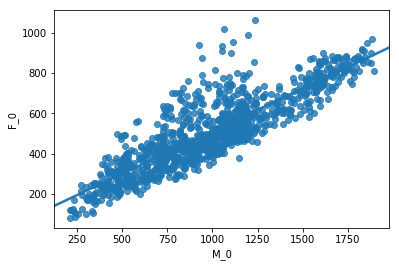

In [66]:
import seaborn as sns
sns.regplot(x='M_0', y='F_0', data=bb)

In [9]:
all_data.columns

Index(['ano_nascimento', 'cidade', 'datetime_cadastro', 'datetime_devolucao',
       'datetime_retirada', 'estacao_devolucao', 'estacao_retirada',
       'id_bicicleta', 'id_usuario', 'pais', 'sexo', 'tipo_usuario',
       'tipo_viagem', 'uf'],
      dtype='object')

In [90]:
def num_


all_data['data_cadastro'] = pd.to_datetime(all_data['data_cadastro'])

date15 = datetime.datetime(2015, 1, 1)
data2014 = all_data[all_data['data_cadastro'] < date15]

date16 = datetime.datetime(2016, 1, 1)
data2015 = all_data[(date15 <= all_data['data_cadastro']) & (all_data['data_cadastro'] < date16)]

date17 = datetime.datetime(2017, 1, 1)
data2016 = all_data[(date16 <= all_data['data_cadastro']) & (all_data['data_cadastro'] < date17)]
data2017 = all_data[date17 <= all_data['data_cadastro']]
data2014.shape[0],data2015.shape[0],data2016.shape[0],data2017.shape[0]


(307830, 1059103, 365981, 103229)

In [186]:
all_data.loc[0]['datetime_retirada'].date()

datetime.date(2014, 12, 16)

In [133]:
num_of_rides_per_year()

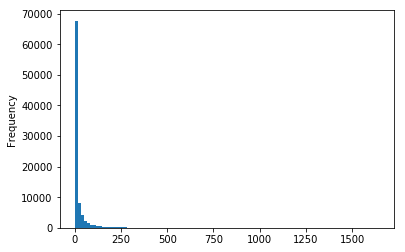

In [113]:
all_data['id_usuario'].value_counts().plot.hist(bins=100)

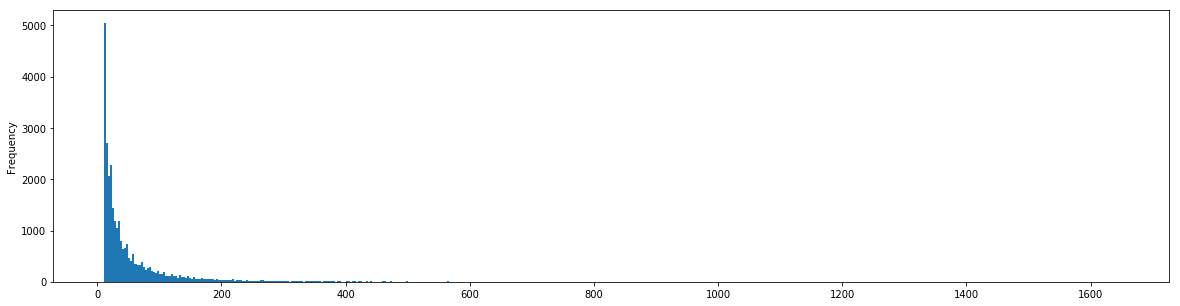

In [140]:
 all_data['id_usuario']

aa = all_data['id_usuario'].value_counts()
aa[aa > 10].plot.hist(bins=500, figsize=(20,5))

In [144]:
aa = pd.DataFrame(aa)

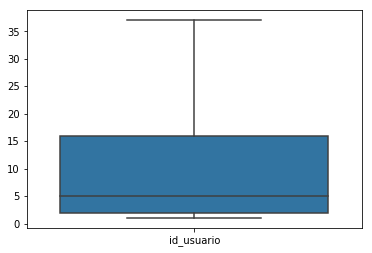

In [148]:
import seaborn as sns
sns.boxplot(data=aa,
                showfliers=False)

# aa.boxplot(figsize=(20,30))

In [151]:
all_data['data_cadastro'] = pd.to_datetime(all_data['data_cadastro'])

dataset = all_data
dataset['ano_cadastro'] = all_data.apply(lambda x: x['data_cadastro'].year, axis=1)
D2014 = dataset[dataset['ano_cadastro'] == 2008]

aa = D2014.groupby(by='sexo', as_index=True).agg({'id_usuario': pd.Series.nunique})

#dataset = dataset.rename(columns={'id_usuario': 'numero_de_cadastros'})
    
#dataset.to_csv('../data/bicicletar/graph_datasets/signup_per_year.csv')

In [175]:
summm = 0
for year in [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]:
    D2014 = dataset[dataset['ano_cadastro'] == year]
    aa = D2014.groupby(by='sexo', as_index=True).agg({'id_usuario': pd.Series.nunique})
    print(aa)
    print('Ano: %d; Total %d' %(year,sum(aa['id_usuario'])))
    summm +=sum(aa['id_usuario'])
    print()
    
    
print('TOTAL',summm)

      id_usuario
sexo            
F              1
M              1
Ano: 2008; Total 2

      id_usuario
sexo            
F              8
M             14
Ano: 2009; Total 22

      id_usuario
sexo            
F             15
M             20
Ano: 2010; Total 35

      id_usuario
sexo            
F             39
M             61
Ano: 2011; Total 100

      id_usuario
sexo            
F            284
M            457
Ano: 2012; Total 741

      id_usuario
sexo            
F            516
M            715
O              1
Ano: 2013; Total 1232

      id_usuario
sexo            
-              3
F           5113
M           6056
O             22
Ano: 2014; Total 11194

      id_usuario
sexo            
-              3
F          21825
M          21259
O             91
Ano: 2015; Total 43178

      id_usuario
sexo            
F           9873
M          10575
O            105
Ano: 2016; Total 20553

      id_usuario
sexo            
0              1
-              1
F           5416


In [163]:
3+5113+6056+22

11194

In [177]:
all_data['id_usuario'].unique().shape

(88433,)